/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_18704/774205161.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `T

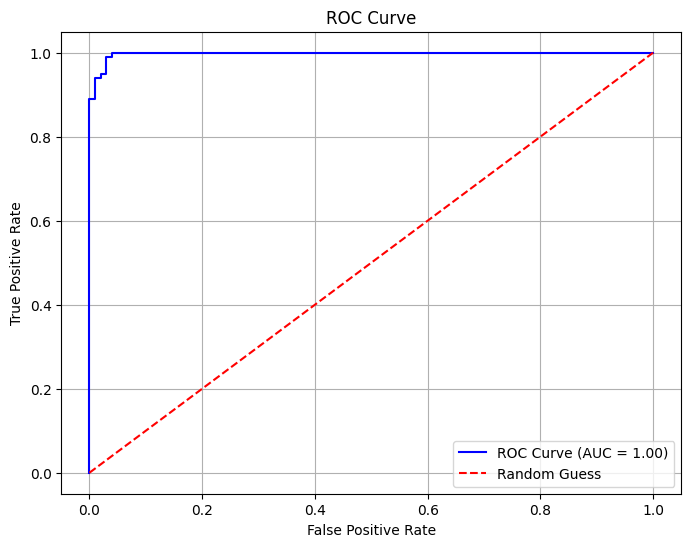


Classification Report:
Accuracy: 0.96
Precision (Uninfected): 0.95
Recall (Uninfected): 0.97
F1-Score (Uninfected): 0.96
Precision (Infected): 0.97
Recall (Infected): 0.95
F1-Score (Infected): 0.96


In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import os
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

# Define Grad-CAM class (not needed for ROC but retained for structure)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for forward activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)
        self.model.zero_grad()
        output[:, target_class].backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load the model architecture and weights
def load_model(model_path):
    model = torchvision.models.vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # Binary classification
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    return model

# Function to predict and generate predictions for ROC Curve
def predict_and_generate_predictions(model, image_path):
    input_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)[:, 1].cpu().numpy()  # Probability for 'Infected' class
        predicted_label = torch.argmax(output).item()
    return predicted_label, probabilities

# Function to evaluate all images in a folder
def evaluate_images_in_folder(model, folder_path):
    all_labels = []
    all_probs = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            ground_truth_label = 1 if subfolder == "infected" else 0  # Assuming folder names as labels
            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                predicted_label, probabilities = predict_and_generate_predictions(model, image_path)
                all_labels.append(ground_truth_label)
                all_probs.append(probabilities[0])  # Only interested in the 'Infected' probability

    return all_labels, all_probs

# Function to plot ROC Curve
def plot_roc_curve(labels, probabilities):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model
    model_path = "cancer_model_full_dataset.pth"  # Path to your saved model
    model = load_model(model_path).to(device)

    # Folder path containing images (e.g., "test_eval/infected/" and "test_eval/uninfected/")
    folder_path = "TEST_METRICS"  # Path to the parent folder containing "infected" and "uninfected"

    # Evaluate all images in the folder and collect true labels and predicted probabilities
    all_labels, all_probs = evaluate_images_in_folder(model, folder_path)

    # Plot ROC curve
    plot_roc_curve(all_labels, all_probs)

    # Classification report (optional)
    report = classification_report(all_labels, np.array(all_probs) > 0.5, target_names=["Uninfected", "Infected"], output_dict=True)
    print("\nClassification Report:")
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Precision (Uninfected): {report['Uninfected']['precision']:.2f}")
    print(f"Recall (Uninfected): {report['Uninfected']['recall']:.2f}")
    print(f"F1-Score (Uninfected): {report['Uninfected']['f1-score']:.2f}")
    print(f"Precision (Infected): {report['Infected']['precision']:.2f}")
    print(f"Recall (Infected): {report['Infected']['recall']:.2f}")
    print(f"F1-Score (Infected): {report['Infected']['f1-score']:.2f}")
